In [24]:
import math
import itertools as it
from itertools import combinations
from collections import Counter

import numpy as np
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt

from activation_funcs import *

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text', usetex=False)

In [ ]:
# ============================================================
# 1. Combinatorial helpers
# ============================================================

def integer_partitions(n):
    """Generate integer partitions of n in non-increasing order."""
    def gen(n, max_part):
        if n == 0:
            yield ()
            return
        for x in range(min(n, max_part), 0, -1):
            for rest in gen(n - x, x):
                yield (x,) + rest
    return list(gen(n, n))

def class_size_from_type(n, part):
    """|C_μ| = n! / (Π_i (m_i! * i^{m_i}))"""
    mult = Counter(part)
    denom = 1
    for i, m in mult.items():
        denom *= math.factorial(m) * (i**m)
    return math.factorial(n) // denom

def all_perms(n):
    """All permutations of {0,...,n-1}."""
    return list(it.permutations(range(n)))

def cycle_type(p):
    """Cycle-type partition of permutation p."""
    n = len(p)
    seen = [False]*n
    cyc = []
    for i in range(n):
        if not seen[i]:
            j=i; L=0
            while not seen[j]:
                seen[j]=True
                j=p[j]; L+=1
            cyc.append(L)
    cyc.sort(reverse=True)
    return tuple(cyc)

def conjugacy_classes(n):
    """Brute-force list of conjugacy classes of S_n."""
    classes = {}
    for g in all_perms(n):
        mu = cycle_type(g)
        classes.setdefault(mu, []).append(g)
    out=[]
    for mu, members in classes.items():
        out.append({"type":mu, "size":len(members), "members":members})
    return out


# ============================================================
# 2. k-subset permutation representation ρ : S_n → GL(V_{n,k})
# ============================================================

def k_subsets(n, k):
    if k < 0 or k > n:
        return []
    return [tuple(c) for c in it.combinations(range(n), k)]

def perm_matrix(n, k, sigma):
    """Permutation matrix of σ acting on k-subsets."""
    Xk = k_subsets(n, k)
    idx = {A:i for i,A in enumerate(Xk)}
    m = len(Xk)
    M = np.zeros((m, m))
    for j,A in enumerate(Xk):
        B = tuple(sorted(sigma[a] for a in A))
        M[idx[B], j] = 1.0
    return M


# ============================================================
# 3. Two-row irreducible dimensions and characters
# ============================================================

def dim_two_row(n, i):
    """dim S^{(n-i,i)} = C(n,i) – C(n,i-1)."""
    if i == 0:
        return 1
    if i < 0 or i > n:
        return 0
    return math.comb(n,i) - math.comb(n,i-1)

def chi_two_row(n, i, cycle_type_part):
    """
    χ^{(n-i,i)}(σ) = [x^i] ∏_{m≥1} (1+x^m)^{a_m} − [x^{i−1}]∏_{m≥1}(1+x^m)^{a_m}
    where a_m = # of m-cycles in σ.
    """
    x = sp.symbols('x')
    c = Counter(cycle_type_part)
    P = 1
    for m, am in c.items():
        if am > 0:
            P *= (1 + x**m)**am
    P = sp.expand(P)
    coeff = lambda r: P.expand().coeff(x, r)
    if i == 0:
        return 1
    return coeff(i) - coeff(i-1)


# ============================================================
# 4. Classical character-sum projectors
# ============================================================

def projectors_two_row_characters(n, k, tol=1e-8):
    """
    Compute projectors p_{(n−i,i)} on V_{n,k} = ℝ[X_k]
    using the character-sum formula.
    Returns {i: Qblock_i}, each Qblock_i is ONB for that irrep.
    """
    basis = k_subsets(n, k)
    m = len(basis)
    classes = conjugacy_classes(n)

    # Precompute permutation matrices ρ(g)
    rho = {}
    for C in classes:
        for g in C["members"]:
            rho[g] = perm_matrix(n, k, g)

    proj, Qblocks = {}, {}
    for i in range(0, k+1):
        dimL = dim_two_row(n, i)
        M = np.zeros((m,m))
        for C in classes:
            mu = C["type"]
            chi = float(chi_two_row(n, i, mu))
            S_C = sum(rho[g] for g in C["members"])
            M += chi * S_C
        p = (dimL / math.factorial(n)) * M
        p = (p + p.T)/2   # enforce symmetry
        proj[i] = p

        # Extract eigenvectors with eigenvalue 1
        vals, vecs = np.linalg.eigh(p)
        eig1 = vecs[:, np.where(np.abs(vals-1)<1e-8)[0]]
        Qblocks[i] = eig1
    return proj, Qblocks, basis


# ============================================================
# 5. Interaction graph inside fixed V_{n,k}
# ============================================================

def test_edge_activation(Qblocks, i, j, activation_fn, tol=1e-8):
    Qi, Qj = Qblocks.get(i), Qblocks.get(j)
    if Qi is None or Qj is None or Qi.size == 0 or Qj.size == 0:
        return False
    phi = np.vectorize(activation_fn)
    def leaks(v):
        v_act = phi(v)
        coeffs = Qj.T @ v_act
        return np.any(np.abs(coeffs) > tol)
    for a in range(Qi.shape[1]):
        if leaks(Qi[:,a]): return True
    for a,b in combinations(range(Qi.shape[1]),2):
        if leaks(Qi[:,a]+Qi[:,b]): return True
    return False

def build_interaction_graph(n, k, activation_fn, tol=1e-8, verbose=False):
    if verbose: print(f"Building graph for n={n}, k={k}")
    _, Qblocks, _ = projectors_two_row_characters(n, k, tol)
    irreps = [i for i,Q in Qblocks.items() if Q.shape[1]>0]
    G = nx.DiGraph()
    nodes = [(n-i,i) for i in irreps]; G.add_nodes_from(nodes)
    for i in irreps:
        for j in irreps:
            if test_edge_activation(Qblocks,i,j,activation_fn,tol):
                G.add_edge((n-i,i),(n-j,j))
                if verbose: print(f"Edge {(n-i,i)}→{(n-j,j)}")
    return G


# ============================================================
# 6. Visualisation
# ============================================================

def interaction_graph(G, title="Interaction graph inside V_{n,k}"):
    fig, ax = plt.subplots(figsize=(7,7))
    pos = nx.spring_layout(G, seed=42)

    # Separate bidirectional and single edges
    bidir_edges = []
    single_edges = []
    for u,v in G.edges():
        if G.has_edge(v,u) and (v,u) not in bidir_edges:
            bidir_edges.append((u,v))
        elif not G.has_edge(v,u):
            single_edges.append((u,v))

    nx.draw_networkx_nodes(G,pos,node_color="#E8F0FF",edgecolors="blue",
                           node_size=1000,linewidths=1.2)
    nx.draw_networkx_labels(G,pos,font_size=11,font_weight="bold")
    nx.draw_networkx_edges(G,pos,edgelist=single_edges,edge_color="black",
                           arrows=True,arrowsize=25,width=1.4)
    nx.draw_networkx_edges(G,pos,edgelist=bidir_edges,edge_color="blue",
                           arrows=True,arrowsize=25,width=2.2)
    ax.set_title(title); ax.axis("off")
    plt.show()


# ============================================================
# 7. Grid of interaction graphs
# ============================================================

def grid_interaction_graph(N_list, k_list, activation_functions, tol=1e-8, save=None):
    """
    Grid of interaction graphs.
    Rows correspond to (N,k) pairs.
    Columns correspond to activation functions.
    Each row is labeled on the left with 'N = ..., k = ...'
    """
    num_rows = len(N_list)
    num_cols = len(activation_functions)
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(4 * num_cols, 4 * num_rows))
    
    # handle single-row/column cases gracefully
    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = axes.reshape(-1, 1)

    for r, (n, k) in enumerate(zip(N_list, k_list)):
        for c, phi in enumerate(activation_functions):
            ax = axes[r, c]

            # --- Build the interaction graph ---
            G = build_interaction_graph(n, k, phi, tol=tol)
            pos = nx.spring_layout(G, seed=42)

            # --- Split edges into single/bidirectional ---
            bidir_edges, single_edges = [], []
            for u, v in G.edges():
                if G.has_edge(v, u) and (v, u) not in bidir_edges:
                    bidir_edges.append((u, v))
                elif not G.has_edge(v, u):
                    single_edges.append((u, v))

            # --- Draw graph ---
            nx.draw_networkx_nodes(G, pos, node_color="#E8F0FF",
                                   edgecolors="blue", node_size=600, ax=ax)
            nx.draw_networkx_labels(G, pos, font_size=9,
                                    font_weight="bold", ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=single_edges,
                                   edge_color="black", arrows=True,
                                   arrowsize=12, width=1.2, ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=bidir_edges,
                                   edge_color="blue", arrows=True,
                                   arrowsize=12, width=2.0, ax=ax)
            ax.axis("off")

            # --- Column and row labels ---
            if r == 0:
                ax.set_title(phi.__name__, fontsize=12, pad=15)

        # Add LaTeX-styled text label for the row (N,k)
        fig.text(
            0.04,                                # x position (near left)
            (num_rows - r - 0.5) / num_rows,     # y position per row
            rf"$N={n},\,k={k}$",                 # LaTeX label
            ha="left", va="center", fontsize=13
        )

    plt.tight_layout(rect=[0.15, 0.08, 1, 0.95])  # left, bottom, right, top
    if save:
        plt.savefig(save, dpi=300, bbox_inches="tight")
    plt.show()


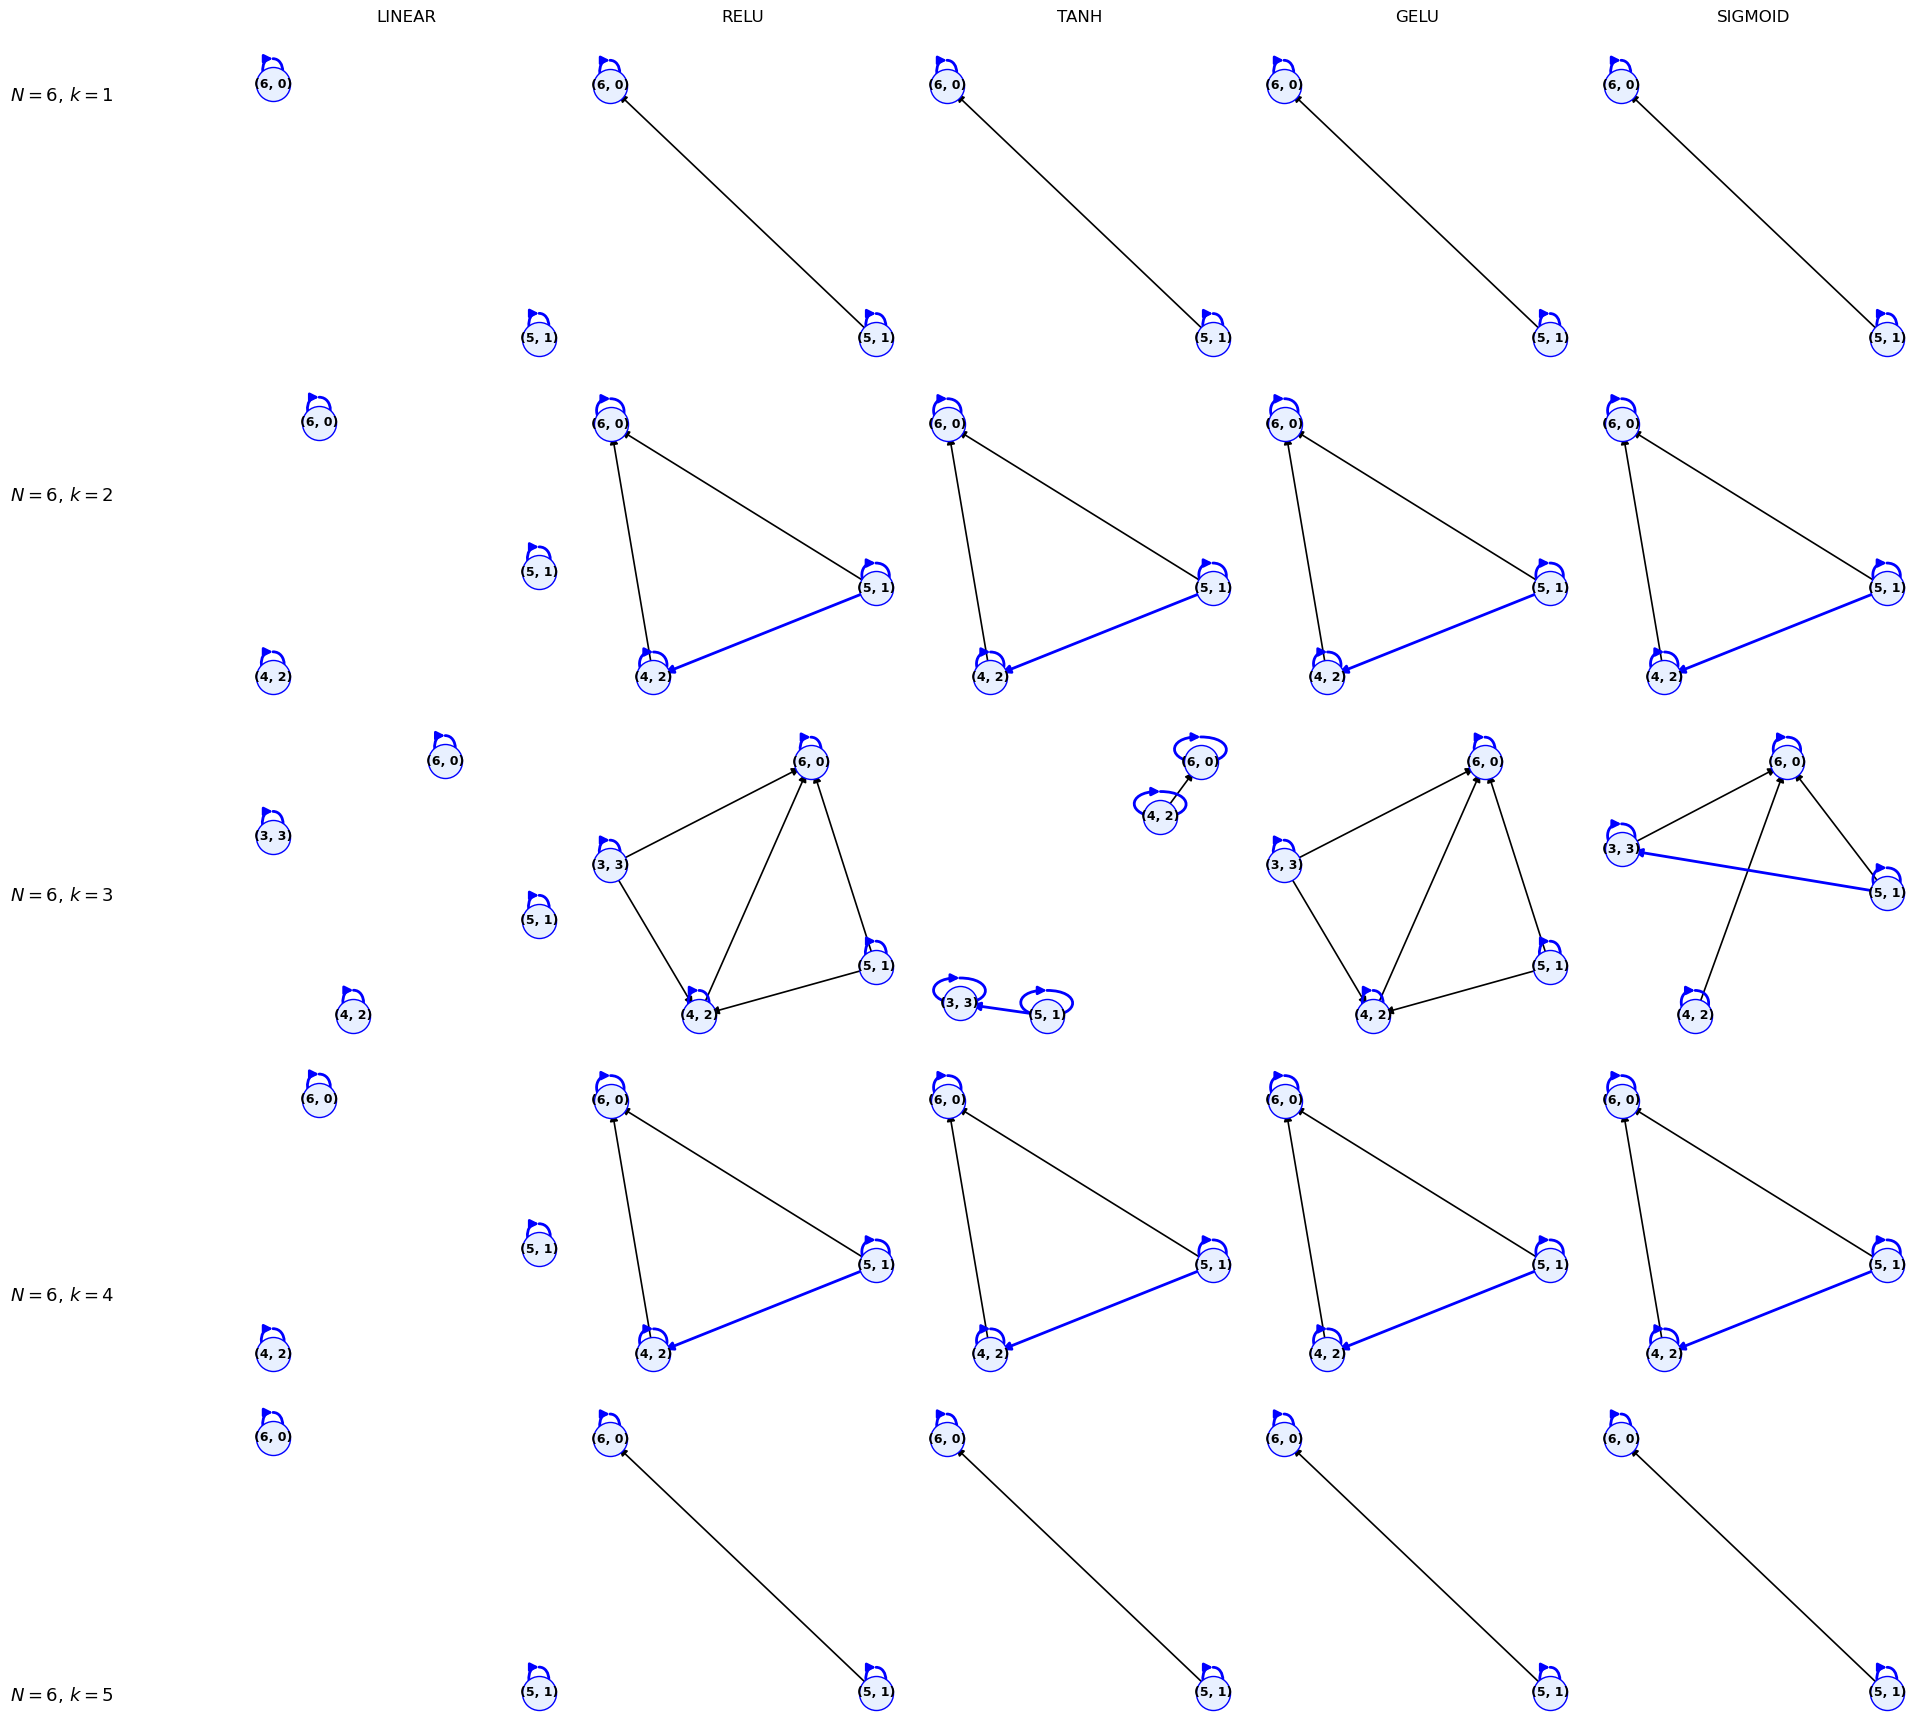

In [43]:
activation_functions = [LINEAR, RELU, TANH, GELU, SIGMOID]
N_list = [6,6,6,6,6]
k_list = [1,2,3,4,5]

grid_interaction_graph(N_list, k_list, activation_functions)